In [1]:
import pathlib
import os

mainDir = pathlib.Path().resolve()

In [2]:
mainDir

WindowsPath('D:/study/ml/book/IMBDFull')

In [3]:
imdb_dir = os.path.join(mainDir, 'aclImdb')
train_dir = os.path.join(imdb_dir, 'train')

In [4]:
import codecs

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = codecs.open(os.path.join(dir_name, fname), "r", "utf_8_sig" )
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen=100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequence = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index))

data = pad_sequences(sequence, maxlen=maxlen)

labels = np.asarray(labels)
print(data.shape)
print(labels.shape)

c:\users\ni_po\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\ni_po\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\users\ni_po\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


88582
(25000, 100)
(25000,)


In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples+validation_samples]
y_val = labels[training_samples: training_samples+validation_samples]

In [7]:
imdb_dir = os.path.join(imdb_dir, 'glove')

embeddings_index = {}
f = codecs.open(os.path.join(imdb_dir, 'glove.6B.100d.txt'), "r", "utf_8_sig" )
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(len(embeddings_index))

400000


In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length= maxlen))
model.add(Flatten())
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [14]:
model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

In [15]:
history = model.fit(x_train,y_train, epochs=10, batch_size=32, validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 4s 135ms/step - loss: 1.1504 - acc: 0.5300 - val_loss: 1.0665 - val_acc: 0.4948
Epoch 2/10
7/7 [==============================] - 1s 99ms/step - loss: 0.5685 - acc: 0.7300 - val_loss: 1.1938 - val_acc: 0.4948
Epoch 3/10
7/7 [==============================] - 1s 101ms/step - loss: 0.3443 - acc: 0.9050 - val_loss: 0.9825 - val_acc: 0.5067
Epoch 4/10
7/7 [==============================] - 1s 100ms/step - loss: 0.2391 - acc: 0.9250 - val_loss: 1.9428 - val_acc: 0.4948
Epoch 5/10
7/7 [==============================] - 1s 97ms/step - loss: 0.4024 - acc: 0.8150 - val_loss: 0.8459 - val_acc: 0.5123
Epoch 6/10
7/7 [==============================] - 1s 99ms/step - loss: 0.0967 - acc: 1.0000 - val_loss: 0.9270 - val_acc: 0.5109
Epoch 7/10
7/7 [==============================] - 1s 96ms/step - loss: 0.0783 - acc: 1.0000 - val_loss: 0.7251 - val_acc: 0.5647
Epoch 8/10
7/7 [==============================] - 1s 101ms/step - loss: 0.0395 - acc: 1.0000 -

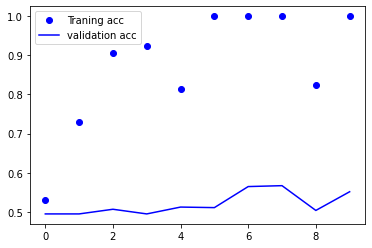

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(0,10), history.history['acc'], 'bo', label='Traning acc')
plt.plot(range(0,10), history.history['val_acc'], 'b', label='validation acc')
plt.legend()


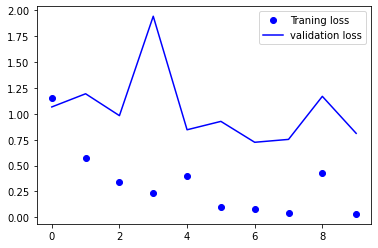

In [24]:
plt.plot(range(0,10), history.history['loss'], 'bo', label='Traning loss')
plt.plot(range(0,10), history.history['val_loss'], 'b', label='validation loss')
plt.legend()